# kaggle: Ultrasound Nerve Segmentation
本次比赛的任务是在超声图像中分割称为臂丛神经(BP)的一组神经.为您提供了一大组图像,其中神经已被人工手动注释.注释员由专家进行培训,并指示注释他们对BP地标的存在感到自信的图像.

- `sample_submission.csv.zip`,6.4KB
- `test.zip`,1.04GB
- `train.zip`,1.07GB
- `train_masks.csv.zip`,748.55KB

文件说明:

- `sample_submission.csv`显示正确的提交文件格式.
- `/test/`包含测试集图像,根据`imageNum.tif`命名,您必须预测这些图像的BP分割.
- `/train/`包含训练集图像,根据`subject_imageNum.tif`命名,具有相同`subject number `的图像来自同一个人,还包括掩码图像.
- `train_masks.csv`以游程编码格式给出训练图像掩码.这是为了方便演示如何将图像蒙版转换为提交的编码文本值.

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

root = Path('/data2/datasets/kaggle/ultrasound-nerve-segmentation')

df_train = pd.read_csv(root/'train_masks.csv')
df_train.head()

,subject,img,pixels
0,1,1,168153 9 168570 15 168984 22 169401 26 169818 ...
1,1,2,96346 7 96762 16 97179 27 97595 35 98012 40 98...
2,1,3,121957 2 122365 26 122784 28 123202 31 123618 ...
3,1,4,110980 9 111393 21 111810 33 112228 43 112647 ...
4,1,5,NaN


`pixels`为`run-length encoded`格式,我们需要将这些数据分割成可以绘制的数据:

In [18]:
pixels = df_train['pixels'].values
print(pixels[0])
p1 = [] # Run-start pixel locations
p2 = [] # Run-lengths
p3 = [] # Number of data points per image

# Separate run-lengths and pixel locations into seperate lists
for p in pixels:
    x = str(p).split(' ')
    for i, m in enumerate(x):
        if i % 2 == 0:
            p1.append(m)
        else:
            p2.append(m)

# Get number of data points in each image
for p in pixels:
    x = str(p).split(' ')
    if len(x) == 1:
        p3.append(0)
    else:
        p3.append(len(x)/2)

# Get all absolute target values
targets = []
for start, length in zip(p1, p2):
    i = 0
    length = int(length)
    if start != 'nan':
        pix = int(start)
        while i <= length:
            targets.append(pix)
            pix += 1
            i += 1

print('\nTotal number of target pixels: ' + str(len(targets)))

# Remove NaNs
p4 = []
i = 0
for p in p1:
    if p == 'nan':
        i += 1
    else:
        p4.append(p)
p1 = p4
print('\nNumber of NaN in pixel locations: ' + str(i))

168153 9 168570 15 168984 22 169401 26 169818 30 170236 34 170654 36 171072 39 171489 42 171907 44 172325 46 172742 50 173159 53 173578 54 173997 55 174416 56 174834 58 175252 60 175670 62 176088 64 176507 65 176926 66 177345 66 177764 67 178183 67 178601 69 179020 70 179438 71 179857 71 180276 71 180694 73 181113 73 181532 73 181945 2 181950 75 182365 79 182785 79 183205 78 183625 78 184045 77 184465 76 184885 75 185305 75 185725 74 186145 73 186565 72 186985 71 187405 71 187825 70 188245 69 188665 68 189085 68 189506 66 189926 65 190346 63 190766 63 191186 62 191606 62 192026 61 192446 60 192866 59 193286 59 193706 58 194126 57 194546 56 194966 55 195387 53 195807 53 196227 51 196647 50 197067 50 197487 48 197907 47 198328 45 198749 42 199169 40 199589 39 200010 35 200431 33 200853 29 201274 27 201697 20 202120 15 202544 6

Total number of target pixels: 16525051

Number of NaN in pixel locations: 3312


In [19]:
print('Number of pixel locations: ' + str(len(p1)))
print('    Number of run lengths: ' + str(len(p2)))
print('\nAverage number of pixel locations per image: ' + str(len(p1) / len(df_train.index)))

Number of pixel locations: 216469
    Number of run lengths: 216469

Average number of pixel locations per image: 38.4150842945874


## 绘图

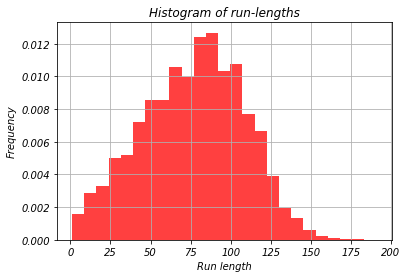

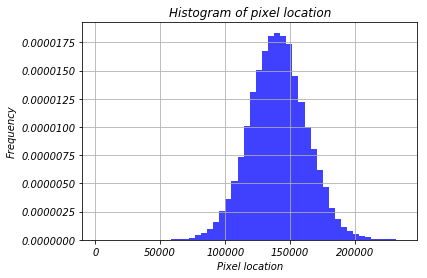

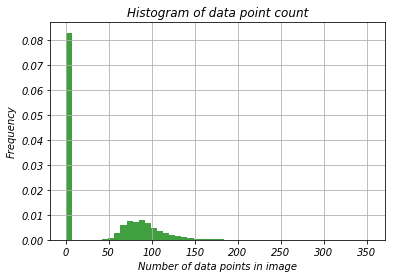

Now let's remove the images with zero target pixels and check again


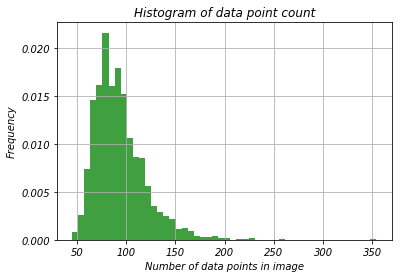

In [20]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import LogNorm

p = np.array(p2).astype(int)
plt.hist(p, 25, normed=1, facecolor='red', alpha=0.75)
plt.title('Histogram of run-lengths')
plt.xlabel('Run length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

p = np.array(p1).astype(int)
plt.hist(p, 50, normed=1, facecolor='blue', alpha=0.75)
plt.title('Histogram of pixel location')
plt.xlabel('Pixel location')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

p = np.array(p3).astype(int)
plt.hist(p, 50, normed=1, facecolor='green', alpha=0.75)
plt.title('Histogram of data point count')
plt.xlabel('Number of data points in image')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print("Now let's remove the images with zero target pixels and check again")

px = []
for x in p.tolist():
    if x != 0:
        px.append(x)

p = np.array(px).astype(int)
plt.hist(p, 50, normed=1, facecolor='green', alpha=0.75)
plt.title('Histogram of data point count')
plt.xlabel('Number of data points in image')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## 分析
首先,我们要将训练数据中的像素值转换为照片上的x和y位置,要做到这一点,我们需要得到图像的尺寸.

In [39]:
import glob, os, cv2
ultrasounds = [img.as_posix() for img in (root/'train').glob('*.tif')]
ultrasounds = [img for img in ultrasounds if 'mask' not in img]

img = cv2.imread(ultrasounds[0])
height, width, channels = img.shape
print('Image dimensions: ' + str(height) + 'h x ' + str(width) + 'w - ' + str(channels) + ' channels')

Image dimensions: 420h x 580w - 3 channels


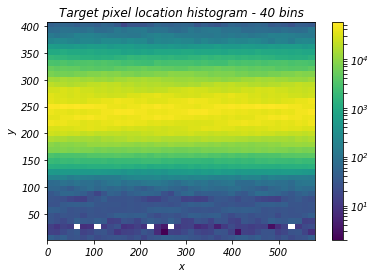

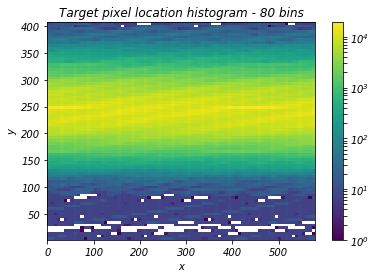

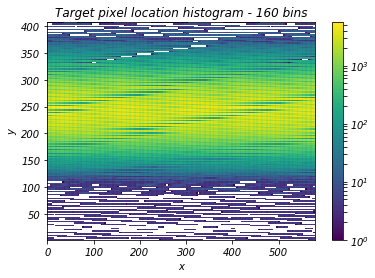

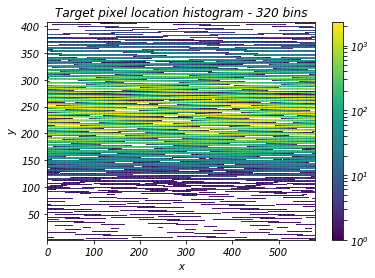

In [40]:
xs = []
ys = []

for p in targets:
    p = int(p)
    xs.append(p % 580)
    ys.append(int(p / 580)) # int() helpfully rounds down

bins = 40
while bins <= 320:
    plt.hist2d(xs, ys, bins=bins, norm=LogNorm())
    plt.colorbar()
    plt.title('Target pixel location histogram - ' + str(bins) + ' bins')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    bins = bins * 2